In [1]:
import sys
import os

# Add the repo root to sys.path
repo_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # adjust as needed
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

from src.votekit.ballot_generator import name_BradleyTerry 
from src.votekit.pref_interval import PreferenceInterval
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
def generate_BT_args(n_cands, alpha=1):
    '''
        generates arguments for name_BradleyTerry with n_cands,
        generates single slate and single bloc, 
    '''
    # num cands goes up to 26
    cands = [chr(ord('a')+i) for i in range(n_cands)]
    bloc_name = "H"
    pref_interval = PreferenceInterval.from_dirichlet(candidates=cands, alpha=alpha)
    pref_intervals_by_bloc = {
        bloc_name: {
            bloc_name : pref_interval
        }
    }
    bloc_voter_prop = {bloc_name: 1}
    cohesion_paramteters = {
        bloc_name: {
            bloc_name: 1
        }
    }
    
    return {
        "candidates": cands,
        "pref_intervals_by_bloc": pref_intervals_by_bloc,
        "bloc_voter_prop" : bloc_voter_prop,
        "cohesion_parameters": cohesion_paramteters
    }

In [3]:
n_cands = 5
## setup the classes
#n_cands = 5
#cands = [chr(ord('a')+i) for i in range(n_cands)] # TODO: need a better way of generating cands which allow us to go larger than 26
#print("candidates: ", cands)

#cands = ["W1", "W2", "C1", "C2"]
# bt = name_BradleyTerry(
#     candidates=cands,
#         pref_intervals_by_bloc={
#             "W": {
#                 "W": PreferenceInterval({"W1": 0.6, "W2": 0.3}),
#                 "C": PreferenceInterval({"C1": 0.05, "C2": 0.05}),
#             },
#             "C": {
#                 "W": PreferenceInterval({"W1": 0.2, "W2": 0.2}),
#                 "C": PreferenceInterval({"C1": 0.3, "C2": 0.3}),
#             },
#         },
#         bloc_voter_prop={"W": 0.9, "C": 0.1 },
#         cohesion_parameters={"W": {"W": 0.5, "C": 0.5}, "C": {"C": 0.9, "W": 0.1}},
#     )

bt = name_BradleyTerry(**generate_BT_args(n_cands=n_cands, alpha=1))

'''
pref_intervals_by_bloc={
            "W": {
                "W": PreferenceInterval({"W1": 0.4, "W2": 0.3}),
                "C": PreferenceInterval({"C1": 0.2, "C2": 0.1}),
            },
            "C": {
                "W": PreferenceInterval({"W1": 0.2, "W2": 0.2}),
                "C": PreferenceInterval({"C1": 0.3, "C2": 0.3}),
            },
        },
        #bloc_voter_prop={"W": 0.7, "C": 0.3},
    '''

def total_variation_distance(P, Q, labels):
    sum = 0 
    for x in labels:
        sum += abs(P[x] - Q[x])
    return (1/2)*sum



In [4]:
# run BT both ways and then process the differences
num_ballots = 10000#int(10e5)
k = 10000
chain_length = num_ballots*10
bals_BT_classic = bt.generate_profile(num_ballots).group_ballots()
#bals_BT_MCMC = bt.generate_profile_MCMC(num_ballots, verbose=False)
bals_BT_MCMC = bt.generate_profile_MCMC(num_ballots, verbose=False, on_shortcut_graph=False).group_ballots()
bals_BT_MCMC_shortcut = bt.generate_profile_MCMC(num_ballots, verbose=False, on_shortcut_graph=True).group_ballots()
bals_BT_MCMC_subsample = bt.generate_profile_MCMC_even_subsample(num_ballots, chain_length, verbose=False).group_ballots()

# Number of bal

The number of ballots before is 100000
The number of ballots after is 10000


False


Text(0.5, 1.0, 'BT samples with MCMC and direct sampling for 5 candidates and 10,000 ballots')

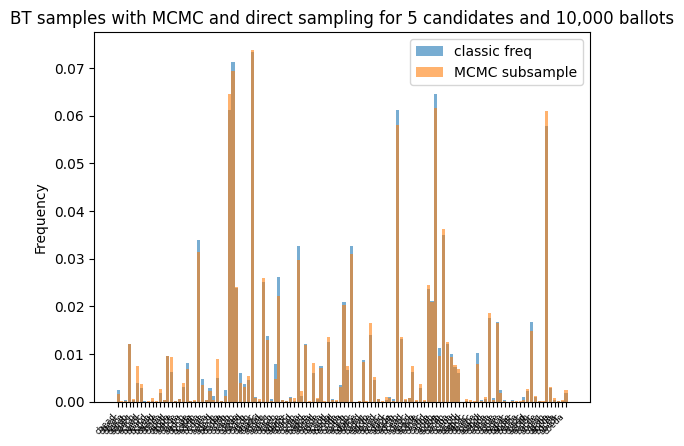

In [6]:
ballot_rankings_MCMC = [bal.ranking for bal in bals_BT_MCMC.ballots]
bal_labels_MCMC = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_MCMC]
bal_weights_MCMC = [int(bal.weight) for bal in bals_BT_MCMC.ballots]

ballot_rankings_MCMC_shortcut = [bal.ranking for bal in bals_BT_MCMC_shortcut.ballots]
bal_labels_MCMC_shortcut = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_MCMC_shortcut]
bal_weights_MCMC_shortcut = [int(bal.weight) for bal in bals_BT_MCMC_shortcut.ballots]

ballot_rankings_classic = [bal.ranking for bal in bals_BT_classic.ballots]
bal_labels_classic = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_classic]
bal_weights_classic = [int(bal.weight) for bal in bals_BT_classic.ballots]

ballot_rankings_MCMC_subsample = [bal.ranking for bal in bals_BT_MCMC_subsample.ballots]
bal_labels_MCMC_subsample = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_MCMC_subsample]
bal_weights_MCMC_subsample = [int(bal.weight) for bal in bals_BT_MCMC_subsample.ballots]

print(bal_labels_classic == bal_labels_MCMC) # labels not in the same order, so set up a map 

# map ballots to weights for each method
bal_rankings_map_classic = {bal_labels_classic[i]: bal_weights_classic[i]/num_ballots for i in range(len(ballot_rankings_classic))}
bal_rankings_map_MCMC = {bal_labels_MCMC[i]: bal_weights_MCMC[i]/num_ballots for i in range(len(ballot_rankings_MCMC))}
bal_rankings_map_MCMC_shortcut = {bal_labels_MCMC_shortcut[i]: bal_weights_MCMC_shortcut[i]/num_ballots for i in range(len(ballot_rankings_MCMC_shortcut))}
bal_rankings_map_MCMC_subsample = {bal_labels_MCMC_subsample[i]: bal_weights_MCMC_subsample[i]/num_ballots for i in range(len(ballot_rankings_MCMC_subsample))}
# convert the bt instance pdfs to a viz-able form

# print(bal_rankings_map_classic)
x_labels = list(bal_rankings_map_classic.keys())

all_keys = [list(m.keys()) for m in [
    bal_rankings_map_classic, bal_rankings_map_MCMC, bal_rankings_map_MCMC_shortcut, bal_rankings_map_MCMC_subsample
]]
flattened_keys = [k for sublist in all_keys for k in sublist]

for key in flattened_keys:
    bal_rankings_map_classic.setdefault(key, 0) 
    bal_rankings_map_MCMC.setdefault(key, 0) 
    bal_rankings_map_MCMC_shortcut.setdefault(key, 0) 
    bal_rankings_map_MCMC_subsample.setdefault(key, 0)

all_keys = list(set(bal_rankings_map_classic) | set(bal_rankings_map_MCMC) | set(bal_rankings_map_MCMC_shortcut) | set(bal_rankings_map_MCMC_subsample))

#plt.bar(all_keys, [bal_rankings_map_MCMC[k] for k in all_keys], label="MCMC freq")
#plt.bar(all_keys, [bal_rankings_map_MCMC_shortcut[k] for k in all_keys], label="MCMC shortcut freq", alpha=0.6)
plt.bar(all_keys, [bal_rankings_map_classic[k] for k in all_keys], label="classic freq", alpha=0.6)
plt.bar(all_keys, [bal_rankings_map_MCMC_subsample[k] for k in all_keys], label="MCMC subsample", alpha=0.6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.legend()
plt.ylabel("Frequency")
plt.title(f"BT samples with MCMC and direct sampling for {n_cands} candidates and {num_ballots:,} ballots")

Text(0.5, 1.0, 'BT samples with MCMC and direct sampling for 5 candidates and 10,000 ballots')

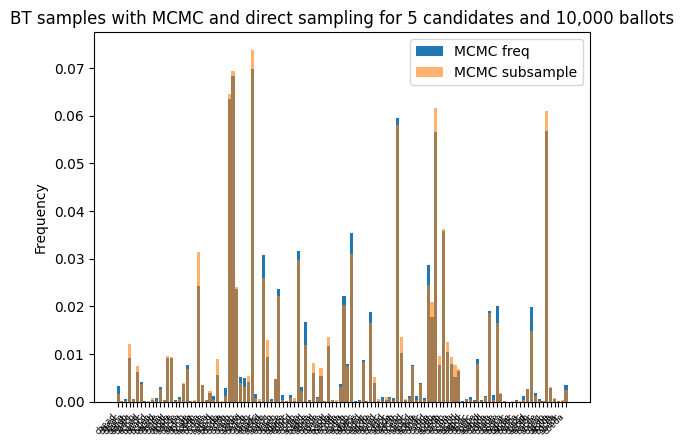

In [7]:
plt.bar(all_keys, [bal_rankings_map_MCMC[k] for k in all_keys], label="MCMC freq")
#plt.bar(all_keys, [bal_rankings_map_classic[k] for k in all_keys], label="classic freq", alpha=0.6)
plt.bar(all_keys, [bal_rankings_map_MCMC_subsample[k] for k in all_keys], label="MCMC subsample", alpha=0.6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.legend()
plt.ylabel("Frequency")
plt.title(f"BT samples with MCMC and direct sampling for {n_cands} candidates and {num_ballots:,} ballots")